# GLM misconceptions

A notebook for thoughts about Cyril Pernet's article on GLM misconceptions

> Misconceptions in the use of the General Linear Model applied to functional MRI: a tutorial for junior neuro-imagers.
> Front. Neurosci., 21 January 2014, https://doi.org/10.3389/fnins.2014.00001

Original notebook created by Mathew Brett: https://github.com/practical-neuroimaging/pna-notebooks/blob/master/Introducing%20the%20General%20Linear%20Model.ipynb

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

Import statistical distributions from scipy:

In [3]:
from scipy.stats import t as t_dist, f as f_dist, gamma

A routine to scale the design matrix for display:

In [4]:
def scale_design_mtx(X):
    """utility to scale the design matrix for display

    This scales the columns to their own range so we can see the variations 
    across the column for all the columns, regardless of the scaling of the 
    column.
    """
    mi, ma = X.min(axis=0), X.max(axis=0)
    col_neq = (ma - mi) > 1.e-8
    Xs = np.ones_like(X)
    mi = mi[col_neq]
    ma = ma[col_neq]
    Xs[:,col_neq] = (X[:,col_neq] - mi)/(ma - mi)
    return Xs

Display the design matrix nicely:

In [5]:
def show_design(X, design_title, **kwargs):
    """ Show the design matrix nicely """
    plt.figure()
    plt.gray() # Gray colormap
    plt.imshow(scale_design_mtx(X), interpolation='nearest', **kwargs)
    plt.title(design_title)

Very simple t statistic from contrast and Ordinary Least Squares fit:

In [6]:
def fit_ols(Y, X):
    """ betas, fitted data, and residuals from OLS linear fit.
    
    This is OLS estimation; we assume the errors to have independent
    and identical normal distributions around zero for each $i$ in 
    $\Epsilon_i$ (i.i.d)
    """
    Y = np.asarray(Y)
    X = np.asarray(X)
    # Get the estimated betas
    betah   =  npl.pinv(X).dot(Y)
    fitted =  X.dot(betah)
    resid   =  Y - fitted
    return betah, fitted, resid

In [7]:
def t_stat(Y, X, C):
    """ betas, t statistic and significance test given data, design matrix, contrast
    
    Ordinary least squares estimation - see `fit_ols` function.
    """
    Y = np.asarray(Y)
    X = np.asarray(X)
    C = np.atleast_2d(C)
    # Calculate the parameters
    B, fitted, resid = fit_ols(Y, X)
    # Residual sum of squares
    RSS   = (resid**2).sum(axis=0)
    # Degrees of freedom - number of observations - number of fitted parameters
    df =  X.shape[0] - npl.matrix_rank(X)
    # Mean residual sum of squares
    MRSS  = RSS / df
    # Standard error of contrast estimate C.dot(B)
    SE    = np.sqrt(MRSS * C.dot(npl.pinv(X.T.dot(X)).dot(C.T)))
    t     = C.dot(B)/SE
    ltp   = t_dist(df).cdf(t) # lower tail p
    p = 1 - ltp # upper tail p
    return B, t, df, p

Make the simulated data from C.P.s figure 2 (was figure 1):

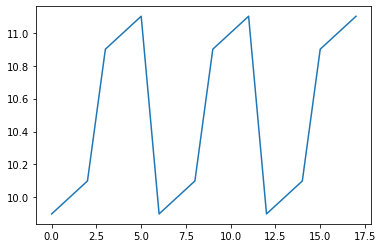

In [8]:
a_block = np.array([-0.1, 0, 0.1])
baseline = 10
activation = 11
on_off = np.hstack((a_block + baseline, a_block + activation))
n_on_off = 3
e = np.tile(a_block, (2 * n_on_off,))
y = np.tile(on_off, (n_on_off,))
plt.plot(y)

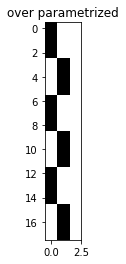

In [9]:
x_on = np.hstack((np.zeros(len(a_block)), np.ones(len(a_block))))
x_off = 1 - x_on
X_over_part = np.column_stack((x_on, x_off, np.ones_like(x_on)))
X_over = np.tile(X_over_part, (n_on_off, 1))
show_design(X_over, 'over parametrized')

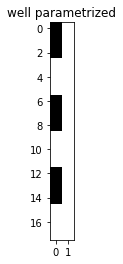

In [10]:
X_well_part = np.column_stack((x_on, np.ones_like(x_on)))
X_well = np.tile(X_well_part, (n_on_off, 1))
show_design(X_well, 'well parametrized')

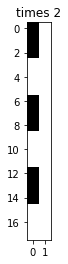

In [11]:
X_times2 = X_well.copy()
X_times2[:, 0] *= 2
show_design(X_times2, 'times 2')

In [12]:
B_over = npl.pinv(X_over).dot(y)
B_over

array([4., 3., 7.])

In [13]:
# Print betas, t statistic, df, p value for different designs, contrasts
print(t_stat(y, X_over, [1, 0, 0]))
print(t_stat(y, X_well, [1, 0]))
print(t_stat(y, X_times2, [1, 0]))

(array([4., 3., 7.]), array([[185.90320062]]), 16, array([[0.]]))
(array([ 1., 10.]), array([[24.49489743]]), 16, array([[2.0539126e-14]]))
(array([ 0.5, 10. ]), array([[24.49489743]]), 16, array([[2.0539126e-14]]))


The t statistic on the over-parametrized design does not relflect the estimability of the contrast:

In [14]:
def is_estimable(X, C):
    """ Is a contrast C estimable on a design X
    
    To be estimable, the contrast needs to be orthogonal to the null-space of X.
    The null space of X is all the vectors $k$ such that Xk = 0.
    If $k$ is a vector in the null-space of X, then:
    
    Y = X B + e
    
    and
    
    Y = X (B + k) + e
    
    give the same fit (X B == X (B + k)).
    
    The null space of X is the orthogonal complement of the row-space of X.  So C
    has to be in the row space of X.
    
    A less mathematical way of seeing this is that the information we will need to form
    our betas is made of linear combinations of the rows of X, because the betas are
    constructed from Xt Y. 
    """
    C = np.atleast_2d(C)
    rankX = npl.matrix_rank(X)
    return rankX == npl.matrix_rank(np.vstack((C, X)))

In [15]:
is_estimable(X_over, [1, 0, 0])

False

In [16]:
is_estimable(X_over, [1, -1, 0])

True

In our case, the null space of $\mathbf{X}$ is:

In [17]:
import sympy
X = sympy.Matrix(X_over)
sympy.pretty_print(X.nullspace())

⎡⎡-1.0⎤⎤
⎢⎢    ⎥⎥
⎢⎢-1.0⎥⎥
⎢⎢    ⎥⎥
⎣⎣ 1  ⎦⎦


Any contrast vector not orthogonal to this null space is not estimable. 

Another way of seeing this is to get a minimal set of vectors that "span" the rows of X. These can be found using the svd :

In [21]:
[u, s, vt] = npl.svd(X_over, full_matrices=False)
tol = s.max() * max(X_over.shape) * np.finfo(s.dtype).eps
nz = np.where(s > tol)[0]
print(nz)
vt[np.abs(vt) < tol] = 0
print(vt.T[:,nz])
print("\nNormalize the columns \n")
print(vt.T[:,nz].dot(np.diagflat([1./vt[0,0], 1./vt[1,1]])))

[0 1]
[[-0.40824829 -0.70710678]
 [-0.40824829  0.70710678]
 [-0.81649658  0.        ]]

Normalize the columns 

[[ 1. -1.]
 [ 1.  1.]
 [ 2.  0.]]


So, any contrast that is made of these two is estimable. In particular, what do you think the first column would test for?

Compare to an F test:

In [22]:
def f_stat(Y, X, col):
    """ betas, F statistic and significance test given data, design and column to test
    
    We do the F statistic long hand, by fitting the model with and without the column to test.
    
    This is OLS estimation; we assume the errors to have independent
    and identical normal distributions around zero for each $i$ in 
    $\Epsilon_i$ (i.i.d).
    """
    Y = np.asarray(Y)
    full_X = np.asarray(X)
    # Delete column to make reduced design
    reduced_X = np.delete(full_X, col, 1)
    # fit both designs
    _, _, full_resid = fit_ols(Y, full_X)
    _, _, reduced_resid = fit_ols(Y, reduced_X)
    n_obs = Y.shape[0]
    # Number of parameters used by each design
    n_p_full = npl.matrix_rank(full_X)
    n_p_reduced = npl.matrix_rank(reduced_X)
    # Extra sum of squares
    full_SS = (full_resid ** 2).sum()
    reduced_SS = (reduced_resid ** 2).sum()
    extra_SS = (reduced_SS - full_SS) / (n_p_full - n_p_reduced)
    # F statistic
    F = extra_SS / (full_SS / (n_obs - n_p_full))
    ltp   = f_dist((n_p_full - n_p_reduced), n_obs - n_p_full).cdf(F) # lower tail p
    p = 1 - ltp # upper tail p
    return F, p

In [23]:
f_stat(y, X_well, 0)

(600.0000000000042, 4.118927421359331e-14)

What happens with the over-parametrized design?

In [24]:
f_stat(y, X_over, 0)

/home/remi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


(inf, nan)

Was that what you were expecting?

## Correlated regressors

In [25]:
# Remind ourselves about the t statistic on the over-parametrized design
print(t_stat(y, X_over, [0, 0, 1]))

(array([4., 3., 7.]), array([[514.39284598]]), 16, array([[0.]]))


In [26]:
# Add a tiny bit of noise to the over-parametrized design
X_over_tweaked = X_over.copy()
X_over_tweaked[0, 2] = 1e-14
print(t_stat(y, X_over_tweaked, [0, 0, 1]))

(array([10.8875,  9.9   ,  0.1125]), array([[1.2456822]]), 15, array([[0.11599406]]))


The general case of correlated regressors

In [27]:
# first a quick function to yield two correlated regressor with correlation c
def correlated(c, n=20, seed=None):
    np.random.seed(seed) # To get predictable random numbers
    # generate two uncorrelated regressors
    Y = np.random.normal(0,1,(n,2))
    #make them correlated with mixing matrix M:
    #we want a correlation c between Y[0] and Y[1], with unit variance
    #this is the mixing matrix needed:
    c1 = np.sqrt( (1 + np.sqrt(1-c*c))/2 ) 
    c2 = .5 * c / c1
    M = np.asarray([[c1, c2],[c2, c1]])
    Yc = Y.dot(M)     # Make Yc = MY
    return Yc

In [29]:
n = 20
Xc = correlated(.8, n)
x1c = Xc[:,0]; x2c = Xc[:,1]; 
print(np.corrcoef(Xc.T)[0,1])

y_corr = x1c + 1.5*np.random.normal(size=n) + 10
#x1c = np.random.normal(size=n)
#x2c = np.random.normal(size=n)
X_corr = np.column_stack((x1c, x2c, np.ones_like(x2c)))

C = np.array([1, 0, 0]) # The contrast
t_stat(y_corr, X_corr, C)

0.7439387165850926


(array([ 1.0192249 ,  0.36211656, 10.24377616]),
 array([[1.60118283]]),
 17,
 array([[0.06387702]]))

In [30]:
XtX = X_corr.T.dot(X_corr)
XtX

array([[13.53470412, 11.510145  ,  3.14369263],
       [11.510145  , 18.59925821, -0.46142584],
       [ 3.14369263, -0.46142584, 20.        ]])

In [31]:
npl.pinv(XtX)

array([[ 0.17172301, -0.10700162, -0.02946088],
       [-0.10700162,  0.12046972,  0.0195984 ],
       [-0.02946088,  0.0195984 ,  0.05508296]])

In [32]:
C.dot(npl.pinv(XtX)).dot(C)

0.17172300892266557

In [34]:
#Xc = correlated(.0, n, seed=42)
#y_corr = Xc[:,0] + 1.*np.random.normal(size=n) + 10


n=20
x1c = np.random.normal(size=n)
x2c = np.random.normal(size=n)
y_corr = x1c + 1.*np.random.normal(size=n) + 10
# if you make the data exactly the same, for the 
# experiment to work, you would have to make the correlated regressor 
# different (use the correlated function with the seed not fixed). 
# Otherwise, you are not going to change your t since 
# the amount of the first regressor that is in the data is just going
# to be scaled, and the scaling doesnt change the t-value. In other
# words you are not changing the amount of data variance that can be 
# explained by the part of x1 that is orthogonal to x2, since x1 and 
# x2 directions remains exactly the same.

    
x2c_corr = np.linspace(0.1, 0.999, 15)

dtype = np.dtype(dict(names=['t', 'mss', 'b0', 'b1', 'b2', 'xvar', 'df'],
                      formats=['f8'] * 7))
res = np.zeros(len(x2c_corr), dtype=dtype)

for i, x2c_corr in enumerate(x2c_corr):
    new_x1c = (1 - x2c_corr) * x1c + x2c_corr * x2c
    #Xc = correlated(x2c_corr, n, seed=42)
    #new_x1c = Xc[:,0]; x2c = Xc[:,1];
    #print np.corrcoef(new_x1c,x2c)[0,1]
    X_corr = np.column_stack((new_x1c, x2c, np.ones_like(x2c)))
    y_corr = new_x1c + 1.*np.random.normal(size=n) + 10
    
    betas, res[i]['t'], res[i]['df'], p = t_stat(y_corr, X_corr, C)
    res[i]['b0'], res[i]['b1'], res[i]['b2'] = betas[:]
    fitted = X_corr.dot(betas)
    res[i]['mss'] = ((y_corr - fitted)**2).sum() / res[i]['df']
    res[i]['xvar'] = C.dot(npl.pinv(X_corr.T.dot(X_corr)).dot(C))
#print(mlab.rec2txt(res))

## HRF and temporal derivatives

Now consider a design convolved with an HRF:

In [35]:
def spm_hrf(t):
    """ Return SPM hrf sampled at times `t`
    """
    # gamma.pdf only defined for t > 0
    hrf = np.zeros_like(t, dtype=np.float)
    hrf[t > 0] = gamma.pdf(t[t > 0], 6, 0, 1) - gamma.pdf(t[t > 0], 16, 0, 1) / 6.
    return hrf / np.sum(hrf)

def spm_hrf_d(t):
    """ Return temporal derivative of SPM HRF sampled at times `t`
    """
    # This is what spm does!
    return spm_hrf(t) - spm_hrf(t - 1)

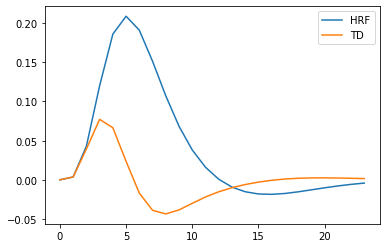

In [36]:
t = np.arange(24)
plt.plot(t, spm_hrf(t), label='HRF')
plt.plot(t, spm_hrf_d(t), label='TD')
plt.legend()

The design without HRF convolution

Smallest singular value (if close to 0 matrix may be rank deficient)
1.9777543696166268e-14


True

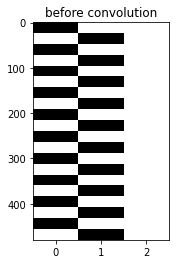

In [37]:
block_length = 24
on_off = np.hstack((np.zeros(block_length), np.ones(block_length)))
off_on = 1 - on_off
X_hrf_over = np.column_stack((on_off, off_on, np.ones_like(on_off)))
X_hrf_over = np.tile(X_hrf_over, (10, 1))
show_design(X_hrf_over, 'before convolution', aspect=0.01)
S = npl.svd(X_hrf_over, compute_uv=False)
print('Smallest singular value (if close to 0 matrix may be rank deficient)')
print(S.min())
# Is -1 -1 1 still in the null space? Yes.
np.allclose(X_hrf_over.dot([-1, -1, 1]), 0)

Design with convolution:

Smallest singular value (if close to 0 matrix may be rank deficient)
1.334323206713798


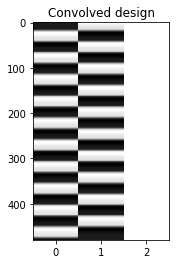

In [38]:
hrf = spm_hrf(t)
x0 = np.convolve(hrf, X_hrf_over[:, 0], mode='same')
x1 = np.convolve(hrf, X_hrf_over[:, 1], mode='same')
X_conv_over = np.column_stack((x0, x1, np.ones_like(x0)))
show_design(X_conv_over, 'Convolved design', aspect=0.01)
S = npl.svd(X_conv_over, compute_uv=False)
print('Smallest singular value (if close to 0 matrix may be rank deficient)')
print(S.min())

Notice that the matrix with convolved columns is no longer rank deficient, and the vector:

$$
\left[\begin{matrix}-1\\-1\\1\end{matrix}\right]
$$

is no longer in the null space (because there is no null space for the convolved matrix).

In [39]:
# Is -1 -1 1 still in the null space?
np.allclose(X_conv_over.dot([-1, -1, 1]), 0)

False

OK, let's make some data based on the design:

In [40]:
x0_hrf = X_conv_over[:, 0]
X_conv_well = np.column_stack((x0_hrf, np.ones_like(x0)))
y = (x0_hrf - x0_hrf.mean()) * 1 + 10

In [41]:
npl.pinv(X_conv_well).dot(y)

array([1.        , 9.49828284])

We don't reconstruct 10 correctly because the ``x0`` regressor does not have mean 0:

In [42]:
x0_hrf.mean()

0.5017171575382599

In [43]:
X_conv_orth = np.column_stack((x0_hrf - x0_hrf.mean(), np.ones_like(x0)))
npl.pinv(X_conv_orth).dot(y)

array([ 1., 10.])

Make a temporal derivative:

In [44]:
dhrf = spm_hrf_d(np.arange(24))
x0_dhrf = np.convolve(dhrf, x0, mode='same')

The derivative is not orthogonal to the HRF, after convolution:

In [45]:
# Basis functions, before convolution with block - nearly orthogonal
hrf.dot(dhrf)

0.010444334170623385

In [46]:
# After convolution with block - not orthogonal
x0_hrf.dot(x0_dhrf)

-12.92987248230584

We can orthogonalize using the same mechamism as we use for the fit:

In [47]:
def orth_x_wrt_y(x, y):
    """ Orthonalize vector `x` with respect to matrix `y`
    """
    y_in_x_beta = npl.pinv(y).dot(x)
    y_in_x = y.dot(y_in_x_beta)
    return x - y_in_x

In [48]:
x0_dhrf_orth = orth_x_wrt_y(x0_dhrf, X_conv_orth)
x0_dhrf_orth.T.dot(X_conv_orth)

array([ 8.77076189e-15, -1.30451205e-15])

In [49]:
x0_hrf.dot(x0_dhrf_orth)

7.734264617642594e-15

As we know, adding an orthogonal regressor to the whole the rest of the design cannot affect the fit for other regressors:

In [50]:
X_dconv_orth = np.column_stack((X_conv_orth[:, 0], x0_dhrf_orth, np.ones_like(x0)))
npl.pinv(X_dconv_orth).dot(y)

array([1.00000000e+00, 2.74780199e-15, 1.00000000e+01])

With or without noise:

In [51]:
ye = y + np.random.normal(size=(y.shape))
print(npl.pinv(X_conv_orth).dot(ye))
print(npl.pinv(X_dconv_orth).dot(ye))

[ 1.00761581 10.10327936]
[ 1.00761581  0.20573618 10.10327936]


But - if the new regressor is not orthogonal to the whole of the rest of the design, the fit can change, even for regressors that *are* orthogonal to the new regressor:

In [52]:
# Design in which hrf regressor not orthogonal to constant
partial_orthed = orth_x_wrt_y(x0_dhrf, x0_hrf[:, None])
X_colinear = np.column_stack((x0_hrf, np.ones_like(x0_hrf)))
X_mixed = np.column_stack((x0_hrf, partial_orthed, np.ones_like(x0_hrf)))
X_mixed.T.dot(X_mixed)

array([[2.43925746e+02, 1.28716482e-15, 2.40824236e+02],
       [1.28716482e-15, 2.57570547e+00, 1.27154540e+01],
       [2.40824236e+02, 1.27154540e+01, 4.80000000e+02]])

So the second temporal derivative regressor is orthogonal to the first HRF regressor, but not orthogonal to the constant.  Estimating:

In [53]:
print(npl.pinv(X_colinear).dot(ye))
print(npl.pinv(X_mixed).dot(ye))

[1.00761581 9.59774122]
[1.01827792 0.20573618 9.5869418 ]


Estimation in the presence of noise caused the parameter for the first HRF regressor to change, even though the added regressor is orthogonal to the first HRF regressor.